In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
# Load the training dataset
train_data = pd.read_csv('mnist_train.csv')
X_train = train_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_train = train_data.iloc[:, 0].values.astype(np.float32)  # Labels

In [3]:
train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load the test dataset
test_data = pd.read_csv('mnist_test.csv')
X_test = test_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_test = test_data.iloc[:, 0].values.astype(np.float32)  # Labels

In [5]:
train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Normalize the data
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [7]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

In [8]:
# Parameters
T = 10000  # Number of synthetic data points to generate
l = 256  # Mixture degree (number of original data points in each mixture)

In [9]:
# Adjust noise levels based on l
sigma_x = 0.0711
sigma_y = 0.0711

In [10]:
# Generate synthetic dataset
def generate_synthetic_data(X, y_one_hot, T, l, sigma_x, sigma_y):
    n, d_X = X.shape  # n: number of original data points, d_X: dimensionality of feature space
    d_y = y_one_hot.shape[1]  # Dimensionality of the one-hot encoded labels
    X_synthetic = np.zeros((T, d_X))  # Initialize the synthetic feature matrix
    y_synthetic = np.zeros((T, d_y))  # Initialize the synthetic label matrix
        

    for t in range(T):
        # Step 1: Select l data points randomly without replacement
        indices = np.random.choice(n, l, replace=False)
        
        # Step 2: Create the weight vector for the mixture
        C_t = np.zeros(n)  # Initialize the weight vector with zeros
        C_t[indices] = 1 / l  # Set the weights of the selected data points to 1 / l
        
        # Step 3: Add Gaussian noise for differential privacy
        Q_t = np.random.normal(0, sigma_x, d_X)  # Gaussian noise for features
        R_t = np.random.normal(0, sigma_y, d_y)  # Gaussian noise for labels
        
        # Step 4: Generate the synthetic data point
        X_synthetic[t] = X.T @ C_t + Q_t  # Weighted sum of selected features plus noise
        y_synthetic[t] = y_one_hot.T @ C_t + R_t  # Weighted sum of selected one-hot labels plus noise

    return X_synthetic, y_synthetic


In [11]:
# Generate the synthetic dataset
X_synthetic, y_synthetic = generate_synthetic_data(X_train, y_train_one_hot, T, l, sigma_x, sigma_y)


In [12]:
print("Maximum value in X_synthetic:", np.max(X_synthetic))
print("Minimum value in X_synthetic:", np.min(X_synthetic))
print("Maximum value in y_synthetic:", np.max(y_synthetic))
print("Minimum value in y_synthetic:", np.min(y_synthetic))

Maximum value in X_synthetic: 0.9005976104014004
Minimum value in X_synthetic: -0.34632760320810335
Maximum value in y_synthetic: 0.4408759561644345
Minimum value in y_synthetic: -0.19412017050546115


In [13]:
# Ensure labels are in the correct format for visualization
y_synthetic_labels_vis = y_synthetic.argmax(axis=1)


In [14]:
# Reshape synthetic data for visualization
X_synthetic_images = X_synthetic.reshape(T, 28, 28)
X_train_images = X_train.reshape(len(X_train), 28, 28)
X_test_images = X_test.reshape(len(X_test), 28, 28)


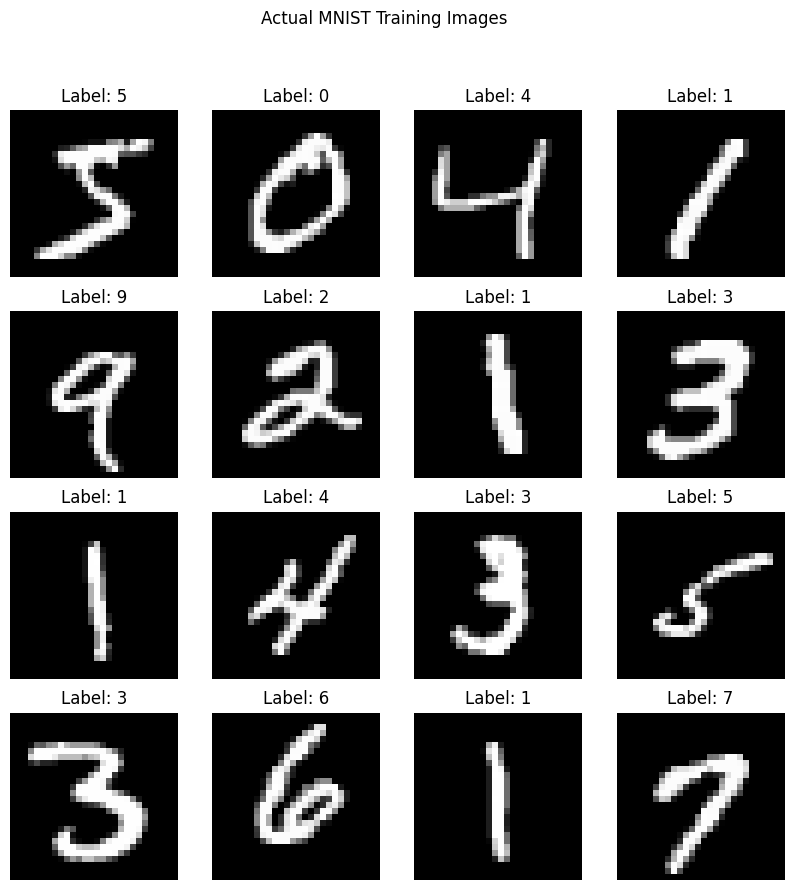

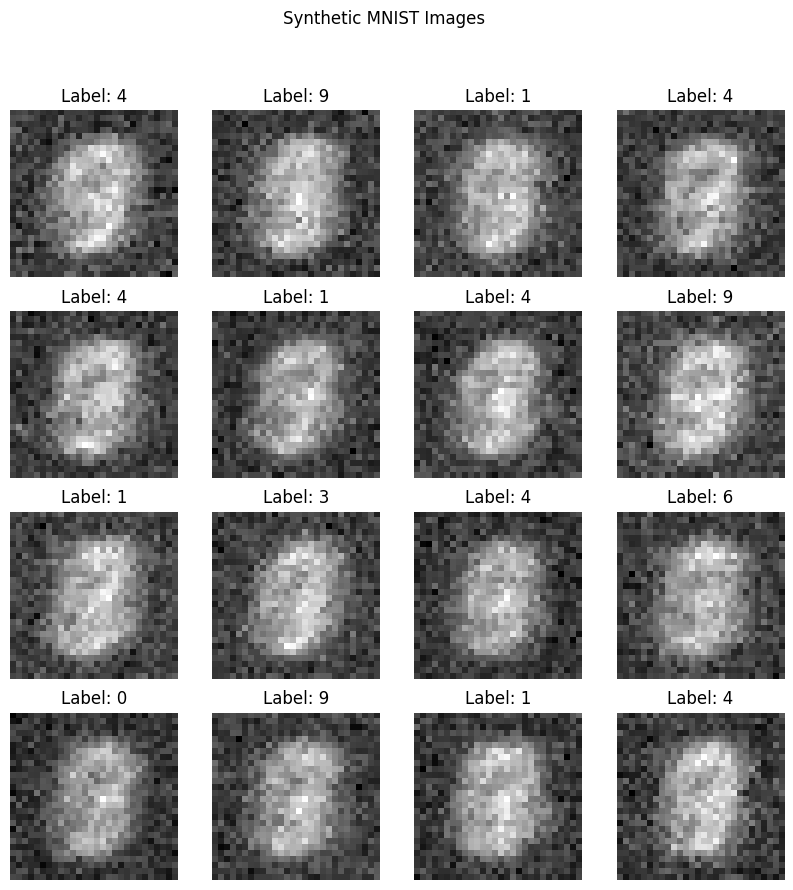

In [15]:
# Function to plot images with their labels
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        label = labels[i].item() if isinstance(labels[i], np.ndarray) else labels[i]
        plt.title(f'Label: {int(label)}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot the first 16 actual MNIST images from the training set
plot_images(X_train_images[:16], y_train[:16], 'Actual MNIST Training Images')

# Plot the first 16 synthetic MNIST images
plot_images(X_synthetic_images[:16], y_synthetic_labels_vis[:16], 'Synthetic MNIST Images')


In [16]:
# Correct negative values and scale synthetic data
X_synthetic[X_synthetic < 0] = 0  # Set all negative values to 0
scaler_synthetic = MinMaxScaler()
X_synthetic = scaler_synthetic.fit_transform(X_synthetic)  # Scale data to [0, 1]

# Correct negative values for labels
y_synthetic[y_synthetic < 0] = 0


In [17]:
# Preprocess the synthetic data for training
X_synthetic_reshaped = X_synthetic.reshape(T, 28, 28, 1)


In [18]:
# Build the CNN model
def build_cnn_model():
    model = models.Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(48, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())    
    model.add(layers.Dense(100, activation='relu'))  
    model.add(layers.Dense(100, activation='relu')) 
    model.add(layers.Dense(10, activation='softmax'))  
    return model

In [19]:
# Compile the CNN model
cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss=KLDivergence(), metrics=['accuracy'])

In [20]:
# Define a checkpoint callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint('models/model5/best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [21]:
# Define the learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch > 0 and (epoch+1) % 10 == 0:
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [22]:
# Train the model on synthetic data for 50 epochs, with the checkpoint and learning rate scheduler callbacks
history = cnn_model.fit(X_synthetic_reshaped, y_synthetic, epochs=50, batch_size=8, validation_split=0.1, callbacks=[checkpoint, lr_scheduler])

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1204 - loss: 0.2979 - val_accuracy: 0.1430 - val_loss: 0.3023 - learning_rate: 1.0000e-04
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1367 - loss: 0.2926 - val_accuracy: 0.1430 - val_loss: 0.3025 - learning_rate: 1.0000e-04
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1282 - loss: 0.2877 - val_accuracy: 0.1430 - val_loss: 0.3018 - learning_rate: 1.0000e-04
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1264 - loss: 0.2970 - val_accuracy: 0.1430 - val_loss: 0.3013 - learning_rate: 1.0000e-04
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1345 - loss: 0.2961 - val_accuracy: 0.1500 - val_loss: 0.3002 - learning_rate: 1.0000e-04
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1450 - loss: 0.2951 - val_accuracy: 0.1490 - val_loss: 0.2999 - learning_rate: 1.0000e-04
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/ste

In [23]:
# Load the best model based on validation accuracy
cnn_model.load_weights('models/model5/best_cnn_model.keras')

In [24]:
# Evaluate the model on original test data
X_test_reshaped = X_test.reshape(len(X_test), 28, 28, 1)
test_loss, test_acc = cnn_model.evaluate(X_test_reshaped, y_test_one_hot)
print('Test accuracy on original data:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6545 - loss: 1.7592
Test accuracy on original data: 0.6834999918937683
